In [1]:
import re
import os, csv, sys 
import scipy
import pandas as pd
import gzip
import xml.etree.ElementTree as ET
from os import listdir
from datetime import datetime
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import random
from netCDF4 import Dataset
import itertools
import geopy.distance
os.chdir('../')
from functions import *

In [26]:
import seaborn as sns

# list of typhoons
-	Typhoon Hagupit (04 Dec 2014) 13:15 UTC  landfall_time_72hr='2014-12-01 12:00:00'
-	Typhoon Melor (14 Dec 2015) landfall_time_72hr='2015-12-11 00:00:00' 
-	Typhoon Lawin (19 Oct 2016) landfall_time_72hr='2016-10-16 12:00:00'

-	Typhoon Nock-ten (25 dec 2016) landfall_time_72hr='2016-12-22 12:00:00'
-	Typhoon Mangkhut (15 sept 2018): landfall_time_72hr='2018-09-12 12:00:00'

-	Typhoon Kammuri (02 dec 2019): landfall_time_72hr='2019-11-29 12:00:00'

-	Typhoon Phanfone (24 dec 2019):landfall_time_72hr='2019-12-21 12:00:00'
-	Typhoon Vongfong (14 may 2020): landfall_time_72hr='2020-01-11 12:00:00'

In [2]:
from datetime import timedelta
def f(x):
    return x[0] - timedelta(hours=x[1] ) 
def f2(x):
    elapsedTime= x[0]- x[1] 
    return elapsedTime.total_seconds()/3600

dict_typhoones={'hagupit':'2014-12-06 13:00:00',
                'melor':'2015-12-14 03:00:00',
                'haima':'2016-10-19 12:00:00',
                'nock-ten':'2016-12-25 10:30:00',
                'mangkhut':'2018-09-14 18:00:00',
                'kammuri':'2019-12-02 22:00:00',
                'phanfone':'2019-12-24 09:00:00',
                'vongfong':'2020-05-14 04:00:00'}

In [3]:
os.getcwd()


'C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\skill_analysis\\new_code'

In [4]:

list(dict_typhoones.values())

['2014-12-06 13:00:00',
 '2015-12-14 03:00:00',
 '2016-10-19 12:00:00',
 '2016-12-25 10:30:00',
 '2018-09-14 18:00:00',
 '2019-12-02 22:00:00',
 '2019-12-24 09:00:00',
 '2020-05-14 04:00:00']

## Create pandaframe from xml files

In [8]:
## Parameters

cyclone_name = 'hagupit'
cyclone_names = [cyclone_name]

data_folder = '../data/CSVS/'
obs_folder = '../data/obs/'
results_folder = '../results/CSVs/'
figures_folder = '../results/figures/'

include_UCL_data = 'y'


In [9]:
#define id for the only cyclones of interest 
namelist=[]
for keys,values in dict_typhoones.items():
    cyclone_name=keys.upper()+values[:4]
    namelist.append(cyclone_name)

#observation 

In [10]:
df_obs = pd.read_csv(obs_folder+'ibtracs.WP.list.v04r00.csv') 
df_obs=df_obs[['SEASON','NUMBER','NAME','ISO_TIME','LAT','LON','WMO_WIND','USA_WIND','TOKYO_WIND', 'CMA_WIND', 'HKO_WIND']]
df_obs['time'] =  pd.to_datetime(df_obs['ISO_TIME'], format='%Y-%m-%d %H:%M:%S')
df_obs=df_obs[df_obs['USA_WIND'] !=" "] 
df_obs["OBS_WIND"] = pd.to_numeric(df_obs["USA_WIND"])
df_obs["OBS_LAT"] = pd.to_numeric(df_obs["LAT"])
df_obs["OBS_LON"] = pd.to_numeric(df_obs["LON"])
df_obs=df_obs[['NAME','SEASON','OBS_LAT','OBS_LON',"OBS_WIND",'time']]
df_obs['cyclon_id']=df_obs[['NAME','SEASON']].apply(lambda x: x[0]+str(x[1]),axis=1)               
df_obs=df_obs[df_obs['cyclon_id'].isin(namelist)]


C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20,23,24,25,38,39,40,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_obs

,NAME,SEASON,OBS_LAT,OBS_LON,OBS_WIND,time,cyclon_id
226395,HAGUPIT,2014,2.10000,156.400,20,2014-11-30 06:00:00,HAGUPIT2014
226396,HAGUPIT,2014,2.43749,156.157,22,2014-11-30 09:00:00,HAGUPIT2014
226397,HAGUPIT,2014,2.76000,155.880,25,2014-11-30 12:00:00,HAGUPIT2014
226398,HAGUPIT,2014,3.19880,155.303,27,2014-11-30 15:00:00,HAGUPIT2014
226399,HAGUPIT,2014,3.54545,154.636,30,2014-11-30 18:00:00,HAGUPIT2014
...,...,...,...,...,...,...,...
236820,VONGFONG,2020,19.30000,120.500,25,2020-05-16 06:00:00,VONGFONG2020
236821,VONGFONG,2020,19.80490,120.790,22,2020-05-16 09:00:00,VONGFONG2020
236822,VONGFONG,2020,20.10000,120.900,19,2020-05-16 12:00:00,VONGFONG2020
236823,VONGFONG,2020,20.12790,120.657,22,2020-05-16 15:00:00,VONGFONG2020


#forecast

In [13]:
df_list=[]
for keys,values in dict_typhoones.items():
    cyclone_name=keys
    landfall_72=datetime.strptime(values, '%Y-%m-%d %H:%M:%S')
    df_store = pd.read_csv(data_folder+cyclone_name+'_all.csv')#,dtype={'lat': np.float64, 'lon': np.float64, 'cyc_speed': np.float64} ) 
    df_store["lon"] = pd.to_numeric(df_store["lon"])
    df_store["lat"] = pd.to_numeric(df_store["lat"])
    df_store['vhr'].replace('none', np.nan, inplace=True)
    df_store["vhr"] = pd.to_numeric(df_store["vhr"])
    df_store['time'] =  pd.to_datetime(df_store['time'], format='%Y/%m/%d, %H:%M:%S')
    df_store['forecast_time'] =  pd.to_datetime(df_store['forecast_time'], format='%Y/%m/%d, %H:%M:%S')
   
    #df_event=df_obs[(df_obs['NAME'].isin([cyclone_name.upper(),cyclone_name.lower()])) & (df_obs['SEASON']==int(values[:4]))]
    #df_event=df_event.set_index('time')
    #df_event=df_event[df_event['USA_WIND'] !=" "] 
    #df_event["OBS_WIND"] = pd.to_numeric(df_event["USA_WIND"])
    #df_event["OBS_LAT"] = pd.to_numeric(df_event["LAT"])
    #df_event["OBS_LON"] = pd.to_numeric(df_event["LON"])
    #df_event=df_event[['NAME','SEASON','OBS_LAT','OBS_LON',"OBS_WIND"]]
    
   
    df_=df_store[df_store['Mtype']=='forecast'][['model_name','time','forecast_time','cyc_speed','lat','lon','vhr','Mtype']]
    df_['NAME']=cyclone_name.upper()
    df_list.append(df_)
    for forecast_time in list(set(df_store['forecast_time'])):
        df_store1=df_store[df_store['forecast_time']==forecast_time]
        df_ensamble=df_store1[df_store1['Mtype']=='ensembleforecast']        
        df=df_ensamble.groupby(['model_name','time'], as_index=False).agg({"cyc_speed": "mean",
                                                                           "lat": "mean",
                                                                           "lon": "mean"})
        df['forecast_time']=forecast_time
        df['vhr']= df[['time','forecast_time']].apply(f2,axis=1)
        
        df['Mtype']='ensembleforecast'       
        df['NAME']=cyclone_name.upper()
        df_list.append(df)
        
df_all = pd.concat(df_list)
    
#df_all['forecast_time']=df_all[['time','vhr']].apply(f, axis=1)
    
#df2 = df_all[(df_all['forecast_time'] >= landfall_72) & (df_all['forecast_time'] <= landfall_72+timedelta(hours=54 ) )]  
  

In [242]:
pd.Timedelta('21600s')

Timedelta('0 days 06:00:00')

In [14]:
df_list2=[]
def leadtime(x):
    if (x[1]-timedelta(hours=78 )) <= x[0] <= (x[1]-timedelta(hours=66 )):
        leadtime=72
    elif (x[1]-timedelta(hours=54 )) <= x[0] <= (x[1]-timedelta(hours=42 )):
        leadtime=48
    elif (x[1]-timedelta(hours=42 )) <= x[0] <= (x[1]-timedelta(hours=30 )):
        leadtime=36
    elif (x[1]-timedelta(hours=30 )) <= x[0] <= (x[1]-timedelta(hours=18 )):
        leadtime=24
    elif (x[1]-timedelta(hours=20 )) <= x[0] <= (x[1]-timedelta(hours=6 )):
        leadtime=12
    else :
        leadtime=np.nan
    return leadtime

def unit_con(x):
    if x[0] in ['ecmwf','mogreps']:
        vmax=np.float(x[1])*1.94384
    else :
        vmax=np.float(x[1])
    return vmax


for elemnts in list(set(df_all['NAME'])):
    df_event=df_all[df_all['NAME']==elemnts]    
    landfall_time=datetime.strptime(dict_typhoones[elemnts.lower()], '%Y-%m-%d %H:%M:%S')
    df_event['landfall_time']=landfall_time
    df_event['leadtime']= df_event[['forecast_time','landfall_time']].apply(leadtime,axis=1)
    df_event['vmax']= df_event[['model_name','cyc_speed']].apply(unit_con,axis=1)
    #df_event = df_event[(df_event['forecast_time'] >= landfall_time-timedelta(hours=72 )) & (df_event['forecast_time'] <= landfall_time )] 
    df_obs_=df_obs[df_obs['NAME']==elemnts]
    for items in set(df_event['forecast_time']):
        df_event_=df_event[df_event['forecast_time']==items]
        for models in list(set(df_event_['model_name'])):
            df_event_2=df_event_[df_event_['model_name']==models]            
            df_combined = pd.merge(df_event_, df_obs_, on='time')           
            df_list2.append(df_combined)
df_all2 = pd.concat(df_list2)        
        #df_combined=pd.merge_asof(df_event_, df_obs_, by='NAME',on='time',tolerance=pd.Timedelta('21600s'))
        
    

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [15]:
df_all2.dropna()

,model_name,time,forecast_time,cyc_speed,lat,lon,vhr,Mtype,NAME_x,landfall_time,leadtime,vmax,NAME_y,SEASON,OBS_LAT,OBS_LON,OBS_WIND,cyclon_id
0,jma-gsm,2016-12-24 06:00:00,2016-12-24 06:00:00,51.400000,13.200000,128.100000,0.0,forecast,NOCK-TEN,2016-12-25 10:30:00,24.0,51.400000,NOCK-TEN,2016,13.300,128.2,120,NOCK-TEN2016
1,gefs,2016-12-24 06:00:00,2016-12-24 06:00:00,82.000000,13.400000,128.100000,0.0,ensembleforecast,NOCK-TEN,2016-12-25 10:30:00,24.0,82.000000,NOCK-TEN,2016,13.300,128.2,120,NOCK-TEN2016
2,jma-teps,2016-12-24 06:00:00,2016-12-24 06:00:00,40.300000,13.200000,128.100000,0.0,ensembleforecast,NOCK-TEN,2016-12-25 10:30:00,24.0,40.300000,NOCK-TEN,2016,13.300,128.2,120,NOCK-TEN2016
3,jma-gsm,2016-12-24 12:00:00,2016-12-24 06:00:00,48.900000,13.300000,127.500000,6.0,forecast,NOCK-TEN,2016-12-25 10:30:00,24.0,48.900000,NOCK-TEN,2016,13.425,127.5,125,NOCK-TEN2016
4,gefs,2016-12-24 12:00:00,2016-12-24 06:00:00,58.857143,13.690476,127.276190,6.0,ensembleforecast,NOCK-TEN,2016-12-25 10:30:00,24.0,58.857143,NOCK-TEN,2016,13.425,127.5,125,NOCK-TEN2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,jma-geps,2020-05-16 06:00:00,2020-05-13 18:00:00,23.953333,18.240000,120.480000,60.0,ensembleforecast,VONGFONG,2020-05-14 04:00:00,12.0,23.953333,VONGFONG,2020,19.300,120.5,25,VONGFONG2020
22,jma-gsm,2020-05-16 12:00:00,2020-05-13 18:00:00,25.000000,19.500000,120.900000,66.0,forecast,VONGFONG,2020-05-14 04:00:00,12.0,25.000000,VONGFONG,2020,20.100,120.9,19,VONGFONG2020
23,jma-geps,2020-05-16 12:00:00,2020-05-13 18:00:00,25.653333,19.300000,120.246667,66.0,ensembleforecast,VONGFONG,2020-05-14 04:00:00,12.0,25.653333,VONGFONG,2020,20.100,120.9,19,VONGFONG2020
24,jma-gsm,2020-05-16 18:00:00,2020-05-13 18:00:00,25.600000,20.300000,121.300000,72.0,forecast,VONGFONG,2020-05-14 04:00:00,12.0,25.600000,VONGFONG,2020,20.000,120.2,25,VONGFONG2020


In [23]:
df_all2=df_all2.dropna()
df_all_combined=df_all2[['model_name','time','forecast_time','vmax','lat','lon','leadtime','Mtype','OBS_LAT','OBS_LON','OBS_WIND','cyclon_id']]
df_all_combined['NAME']=df_all2['NAME_x']
df_all_combined['diff']=df_all2['vmax']-df_all2['OBS_WIND']

def delta1(x):
    delx=(np.float(x[0])-np.float(x[2]))*(np.float(x[0])-np.float(x[2]))
    dely= (np.float(x[1])-np.float(x[3]))*(np.float(x[1])-np.float(x[3]))
    return 110*np.sqrt(delx*dely)


df_all_combined['difflat']=df_all2[['OBS_LAT','OBS_LON','lat','lon']].apply(delta1,axis=1)
 

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be 

#merge 

In [24]:
df_all_combined

,model_name,time,forecast_time,vmax,lat,lon,leadtime,Mtype,OBS_LAT,OBS_LON,OBS_WIND,cyclon_id,NAME,diff,difflat
0,jma-gsm,2016-12-24 06:00:00,2016-12-24 06:00:00,51.400000,13.200000,128.100000,24.0,forecast,13.300,128.2,120,NOCK-TEN2016,NOCK-TEN,-68.600000,1.100000
1,gefs,2016-12-24 06:00:00,2016-12-24 06:00:00,82.000000,13.400000,128.100000,24.0,ensembleforecast,13.300,128.2,120,NOCK-TEN2016,NOCK-TEN,-38.000000,1.100000
2,jma-teps,2016-12-24 06:00:00,2016-12-24 06:00:00,40.300000,13.200000,128.100000,24.0,ensembleforecast,13.300,128.2,120,NOCK-TEN2016,NOCK-TEN,-79.700000,1.100000
3,jma-gsm,2016-12-24 12:00:00,2016-12-24 06:00:00,48.900000,13.300000,127.500000,24.0,forecast,13.425,127.5,125,NOCK-TEN2016,NOCK-TEN,-76.100000,0.000000
4,gefs,2016-12-24 12:00:00,2016-12-24 06:00:00,58.857143,13.690476,127.276190,24.0,ensembleforecast,13.425,127.5,125,NOCK-TEN2016,NOCK-TEN,-66.142857,6.535771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,jma-geps,2020-05-16 06:00:00,2020-05-13 18:00:00,23.953333,18.240000,120.480000,12.0,ensembleforecast,19.300,120.5,25,VONGFONG2020,VONGFONG,-1.046667,2.332000
22,jma-gsm,2020-05-16 12:00:00,2020-05-13 18:00:00,25.000000,19.500000,120.900000,12.0,forecast,20.100,120.9,19,VONGFONG2020,VONGFONG,6.000000,0.000000
23,jma-geps,2020-05-16 12:00:00,2020-05-13 18:00:00,25.653333,19.300000,120.246667,12.0,ensembleforecast,20.100,120.9,19,VONGFONG2020,VONGFONG,6.653333,57.493333
24,jma-gsm,2020-05-16 18:00:00,2020-05-13 18:00:00,25.600000,20.300000,121.300000,12.0,forecast,20.000,120.2,25,VONGFONG2020,VONGFONG,0.600000,36.300000


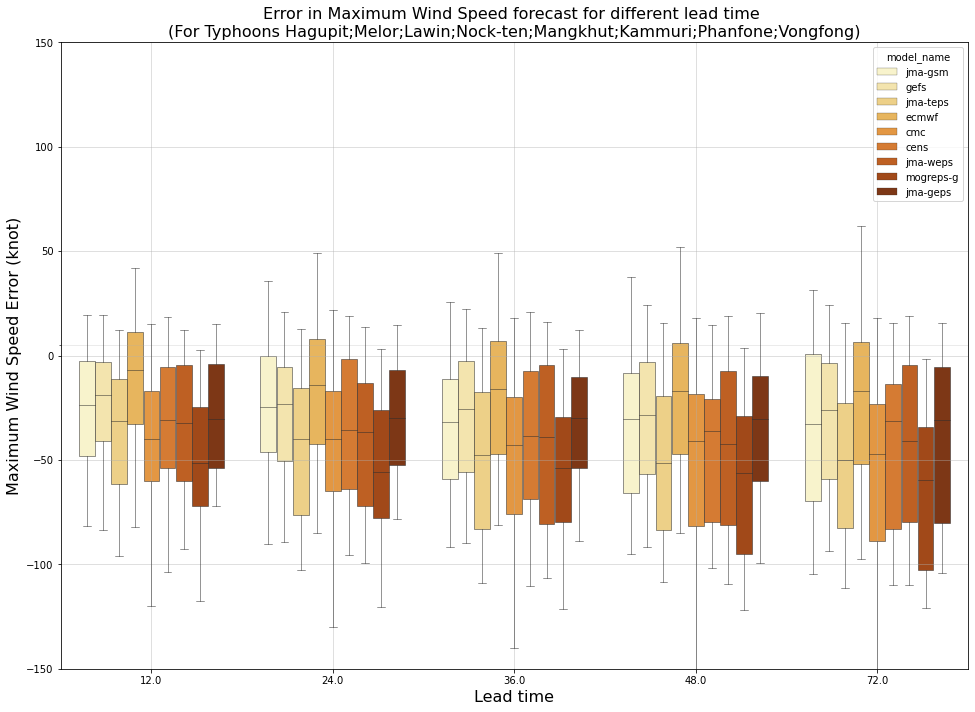

In [40]:
names=list(set(df_all_combined['NAME']))[7]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
combined_df_event=combined_df_event[combined_df_event['model_name']!='mogreps']
fig, ax = plt.subplots(figsize=(18, 12))
plt.subplots_adjust(left=0.2, wspace=0.025,hspace=0.12, top=0.850)
ax = sns.boxplot(data=df_all_combined, x="leadtime", y="diff",hue="model_name",
                 showfliers=False,palette=sns.color_palette("YlOrBr", n_colors=9),linewidth=0.5)
#ax =sns.lineplot(data=combined_df_event, x="leadtime", y="diff",hue="model_name")
#ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-150,150])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
#ax.set_title('Error in intensity different lead time %s'%names,fontsize=16)
ax.set_title('Error in Maximum Wind Speed forecast for different lead time \n(For Typhoons Hagupit;Melor;Lawin;Nock-ten;Mangkhut;Kammuri;Phanfone;Vongfong)',fontsize=16)
ax.set_xlabel('Lead time',fontsize=16)
ax.set_ylabel('Maximum Wind Speed Error (knot)',fontsize=16)
fig.savefig(figures_folder+'max_windspeed_error.jpg', format='jpg', dpi=400)

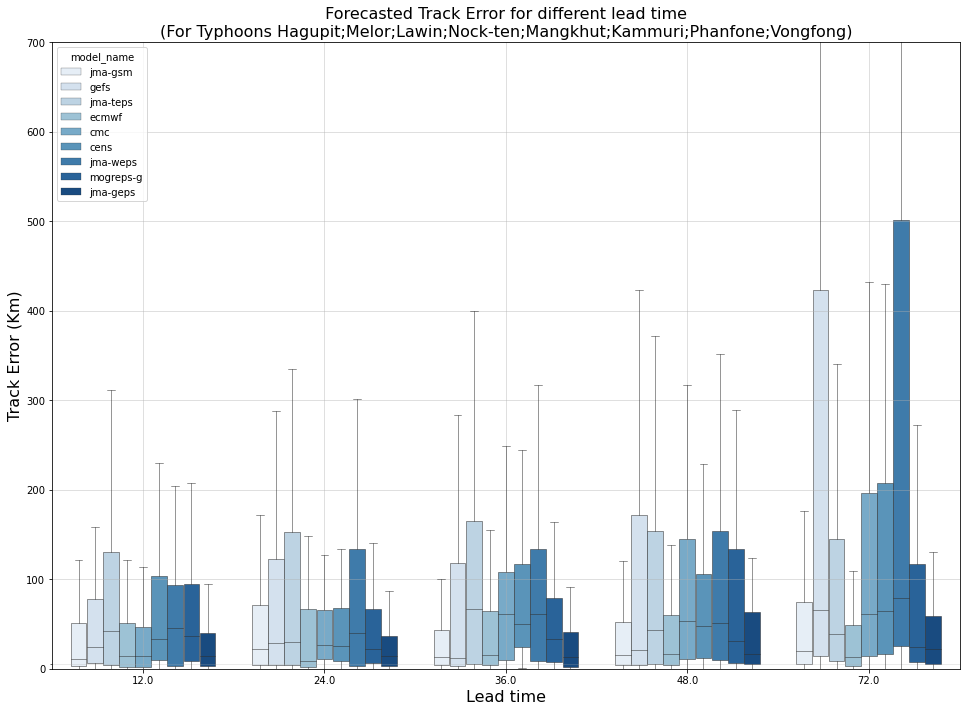

In [42]:
names=list(set(df_all_combined['NAME']))[7]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
combined_df_event=combined_df_event[combined_df_event['model_name']!='mogreps']
fig, ax = plt.subplots(figsize=(18, 12))
plt.subplots_adjust(left=0.2, wspace=0.025,hspace=0.12, top=0.850)
ax = sns.boxplot(data=df_all_combined, x="leadtime", y="difflat",hue="model_name",
                 showfliers=False,palette=sns.color_palette("Blues", n_colors=9),linewidth=0.5)
#ax =sns.lineplot(data=combined_df_event, x="leadtime", y="diff",hue="model_name")
#ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([0,700])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
#ax.set_title('Error in intensity different lead time %s'%names,fontsize=16)
ax.set_title(' Forecasted Track Error for different lead time \n(For Typhoons Hagupit;Melor;Lawin;Nock-ten;Mangkhut;Kammuri;Phanfone;Vongfong)',fontsize=16)
ax.set_xlabel('Lead time',fontsize=16)
ax.set_ylabel('Track Error (Km)',fontsize=16)
fig.savefig(figures_folder+'Track_error.jpg', format='jpg', dpi=400)

Text(0, 0.5, 'vmax Error (knot)')

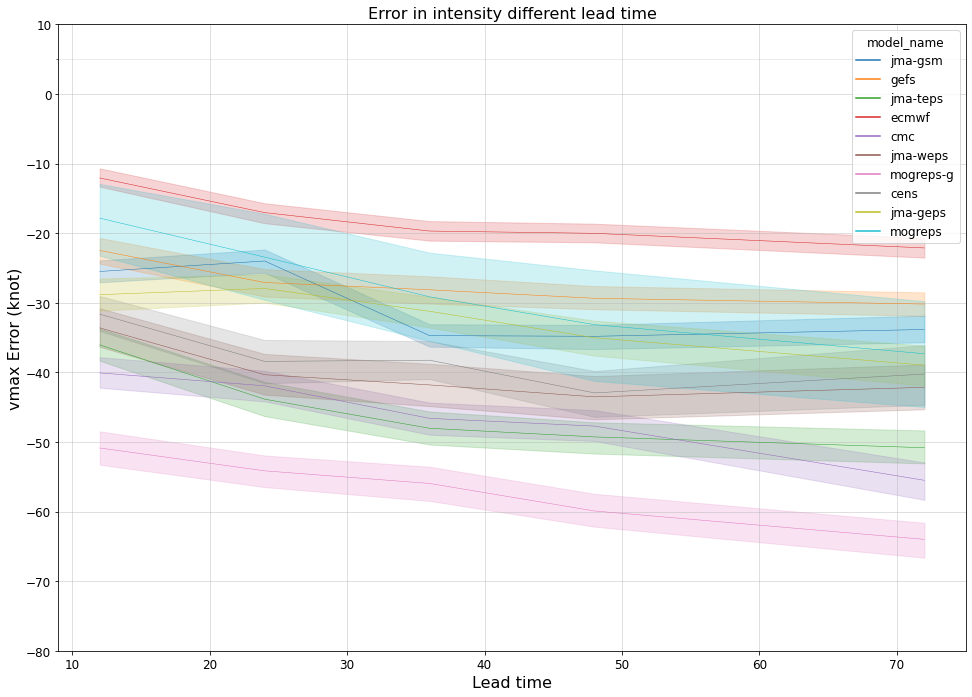

In [349]:

 

fig, ax = plt.subplots(figsize=(18, 12))
plt.subplots_adjust(left=0.2, wspace=0.025,hspace=0.12, top=0.850)
ax =sns.lineplot(data=df_all_combined, x="leadtime", y="diff",hue="model_name",
                 #palette=sns.color_palette("cubehelix", n_colors=8),
                 linewidth=0.5)
#ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-80,10])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
#ax.set_title('Error in intensity different lead time %s'%names,fontsize=16)
ax.set_title('Error in Maximum Wind Speed forecast for different lead time',fontsize=16)
ax.set_xlabel('Lead time',fontsize=16)
ax.set_ylabel('Maximum Wind Speed Error (knot)',fontsize=16)

In [281]:
combined_df_event

,model_name,time,forecast_time,cyc_speed,lat,lon,vhr,Mtype,OBS_LAT,OBS_LON,OBS_WIND,cyclon_id,NAME,diff
0,jma-gsm,2016-10-16 18:00:00,2016-10-16 18:00:00,42.800000,12.100000,137.800000,0.0,forecast,12.2250,137.800,90,HAIMA2016,HAIMA,47.200000
1,gefs,2016-10-16 18:00:00,2016-10-16 18:00:00,65.333333,12.295238,137.900000,0.0,ensembleforecast,12.2250,137.800,90,HAIMA2016,HAIMA,24.666667
2,jma-teps,2016-10-16 18:00:00,2016-10-16 18:00:00,39.796000,12.092000,137.800000,0.0,ensembleforecast,12.2250,137.800,90,HAIMA2016,HAIMA,50.204000
3,jma-gsm,2016-10-17 00:00:00,2016-10-16 18:00:00,49.200000,12.800000,136.700000,6.0,forecast,12.9000,136.625,95,HAIMA2016,HAIMA,45.800000
4,gefs,2016-10-17 00:00:00,2016-10-16 18:00:00,63.904762,12.852381,136.676190,6.0,ensembleforecast,12.9000,136.625,95,HAIMA2016,HAIMA,31.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,jma-gsm,2016-10-21 18:00:00,2016-10-18 06:00:00,59.300000,22.800000,114.400000,84.0,forecast,25.8250,115.408,35,HAIMA2016,HAIMA,-24.300000
43,gefs,2016-10-21 18:00:00,2016-10-18 06:00:00,42.761905,23.252381,114.923810,84.0,ensembleforecast,25.8250,115.408,35,HAIMA2016,HAIMA,-7.761905
44,jma-teps,2016-10-21 18:00:00,2016-10-18 06:00:00,39.668000,23.320000,116.216000,84.0,ensembleforecast,25.8250,115.408,35,HAIMA2016,HAIMA,-4.668000
45,gefs,2016-10-22 00:00:00,2016-10-18 06:00:00,34.714286,23.938095,114.761905,90.0,ensembleforecast,27.4111,116.533,20,HAIMA2016,HAIMA,-14.714286


Text(0, 0.5, 'vmax Error(knot)')

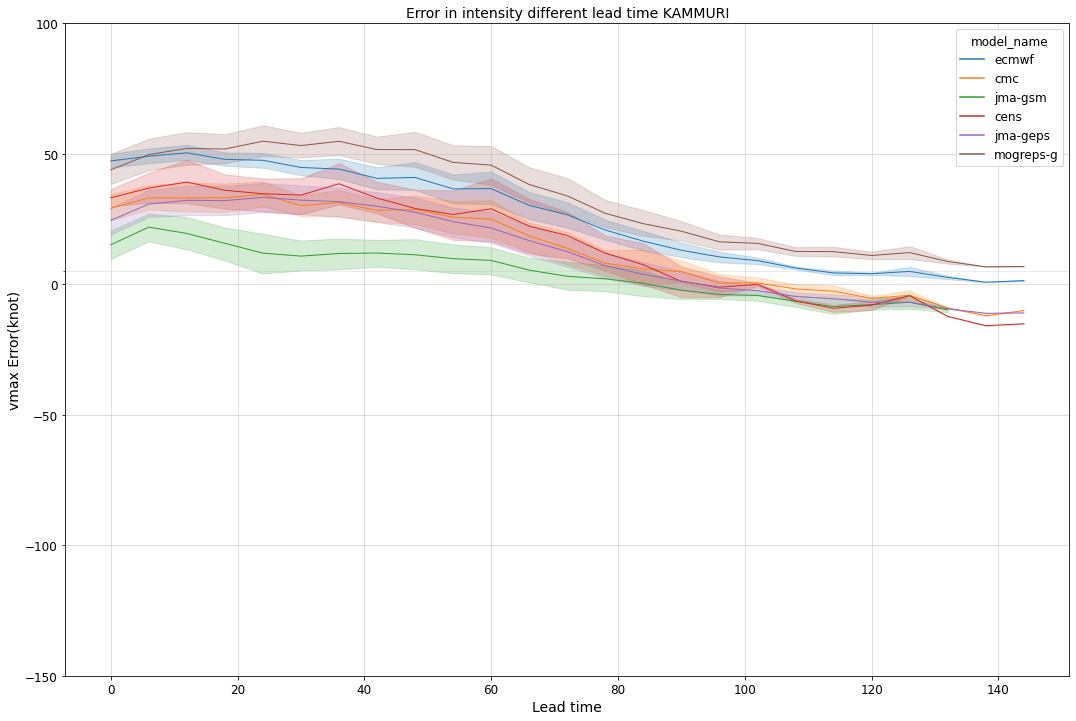

In [279]:
names=list(set(df_all_combined['NAME']))[1]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
#combined_df_event['diff']=combined_df_event['cyc_speed']-combined_df_event['OBS_WIND']


d1=combined_df_event#[combined_df_event['forecast_time']==dict_typhoones[names.lower()]]
#d1=d1[d1['vhr']<=72]
#d1=d1.set_index('time')
#print(d1)

fig, ax = plt.subplots(figsize=(18, 12))
#ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
#ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)
#ax =sns.lineplot(data=d1, x="vhr", y="diff")
ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-150,100])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
ax.set_title('Error in intensity different lead time %s'%names,fontsize=14)
ax.set_xlabel('Lead time',fontsize=14)
ax.set_ylabel('vmax Error(knot)',fontsize=14)

Text(0, 0.5, 'vmax Error(knot)')

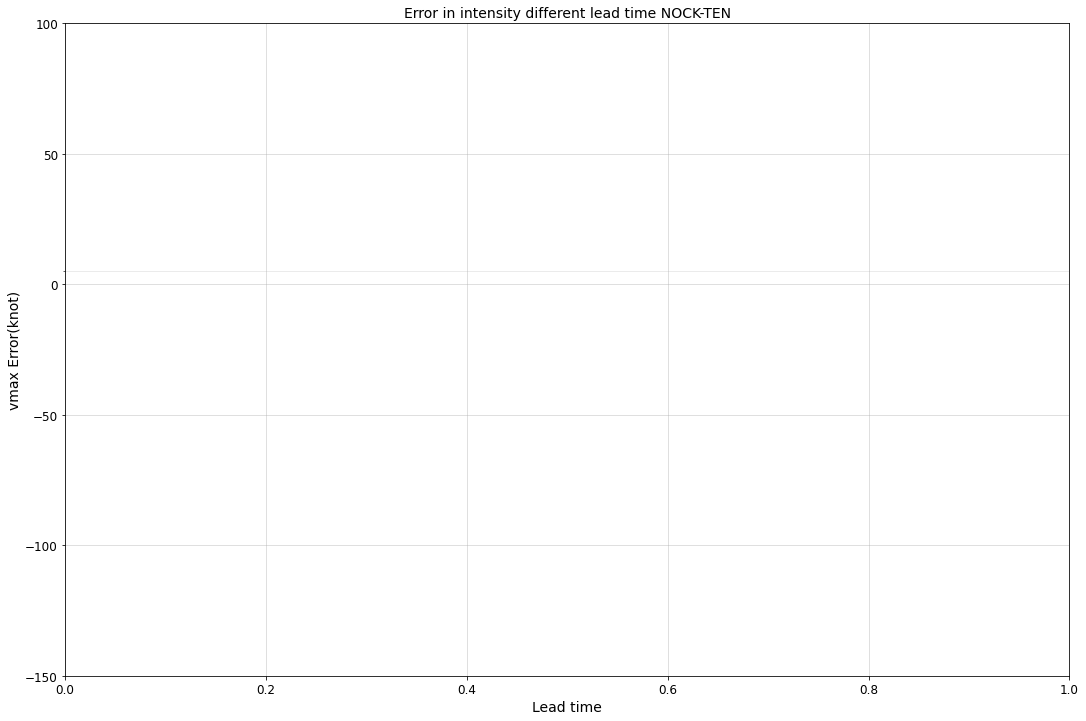

In [274]:
names=list(set(df_all_combined['NAME']))[2]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
#combined_df_event['diff']=combined_df_event['cyc_speed']-combined_df_event['OBS_WIND']


d1=combined_df_event[combined_df_event['forecast_time']==dict_typhoones[names.lower()]]
d1=d1[d1['vhr']<=72]
#d1=d1.set_index('time')
#print(d1)

fig, ax = plt.subplots(figsize=(18, 12))
#ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
#ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)
#ax =sns.lineplot(data=d1, x="vhr", y="diff")
ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-150,100])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
ax.set_title('Error in intensity different lead time %s'%names,fontsize=14)
ax.set_xlabel('Lead time',fontsize=14)
ax.set_ylabel('vmax Error(knot)',fontsize=14)

Text(0, 0.5, 'vmax Error(knot)')

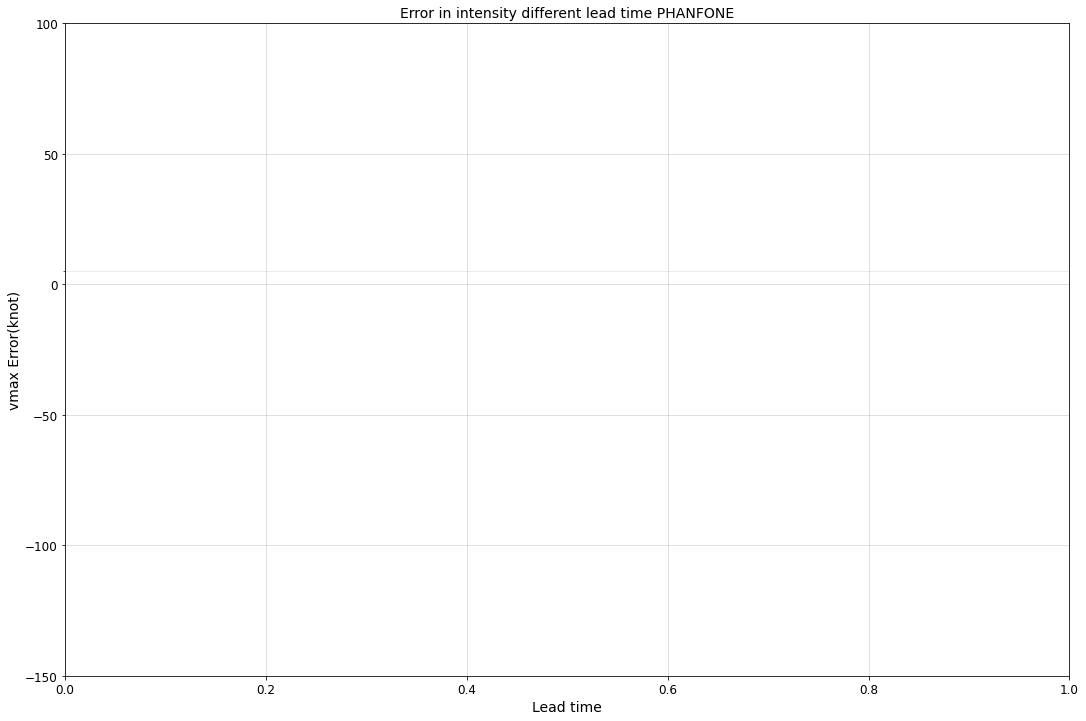

In [275]:
names=list(set(df_all_combined['NAME']))[3]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
#combined_df_event['diff']=combined_df_event['cyc_speed']-combined_df_event['OBS_WIND']


d1=combined_df_event[combined_df_event['forecast_time']==dict_typhoones[names.lower()]]
d1=d1[d1['vhr']<=72]
#d1=d1.set_index('time')
#print(d1)

fig, ax = plt.subplots(figsize=(18, 12))
#ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
#ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)
#ax =sns.lineplot(data=d1, x="vhr", y="diff")
ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-150,100])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
ax.set_title('Error in intensity different lead time %s'%names,fontsize=14)
ax.set_xlabel('Lead time',fontsize=14)
ax.set_ylabel('vmax Error(knot)',fontsize=14)

Text(0, 0.5, 'vmax Error(knot)')

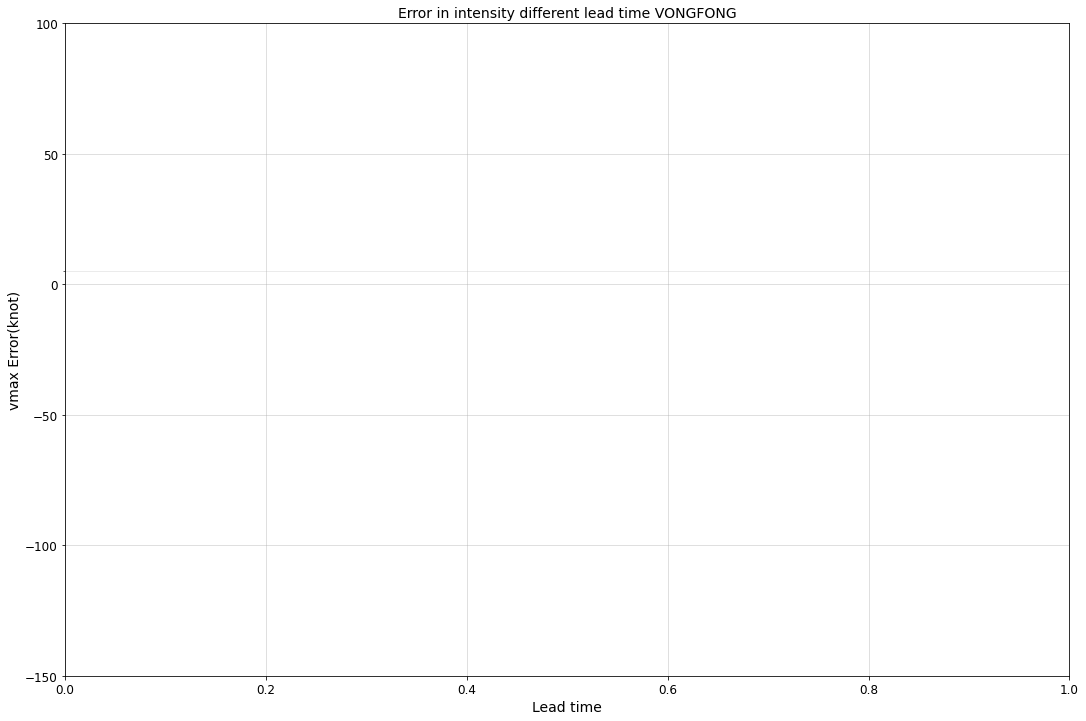

In [276]:
names=list(set(df_all_combined['NAME']))[4]
combined_df_event=df_all_combined[df_all_combined['NAME']==names]
#combined_df_event['diff']=combined_df_event['cyc_speed']-combined_df_event['OBS_WIND']


d1=combined_df_event[combined_df_event['forecast_time']==dict_typhoones[names.lower()]]
d1=d1[d1['vhr']<=72]
#d1=d1.set_index('time')
#print(d1)

fig, ax = plt.subplots(figsize=(18, 12))
#ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
#ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)
#ax =sns.lineplot(data=d1, x="vhr", y="diff")
ax = sns.lineplot(x="vhr", y="diff",hue="model_name", data=d1,linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-150,100])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
ax.set_title('Error in intensity different lead time %s'%names,fontsize=14)
ax.set_xlabel('Lead time',fontsize=14)
ax.set_ylabel('vmax Error(knot)',fontsize=14)

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

ValueError: min() arg is an empty sequence

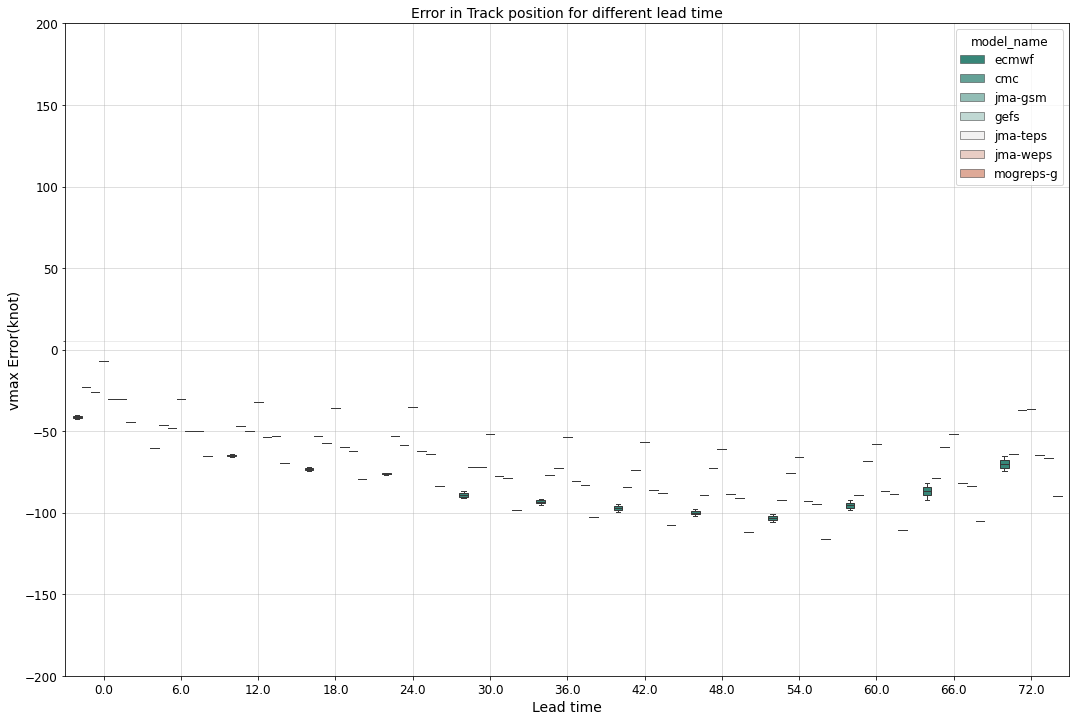

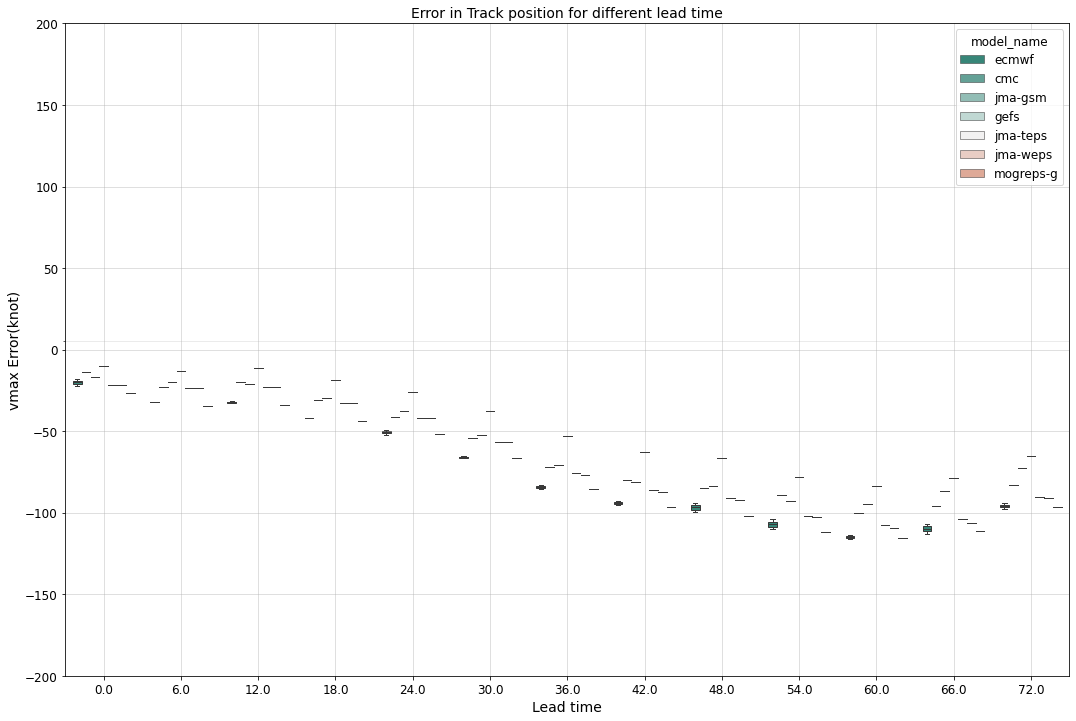

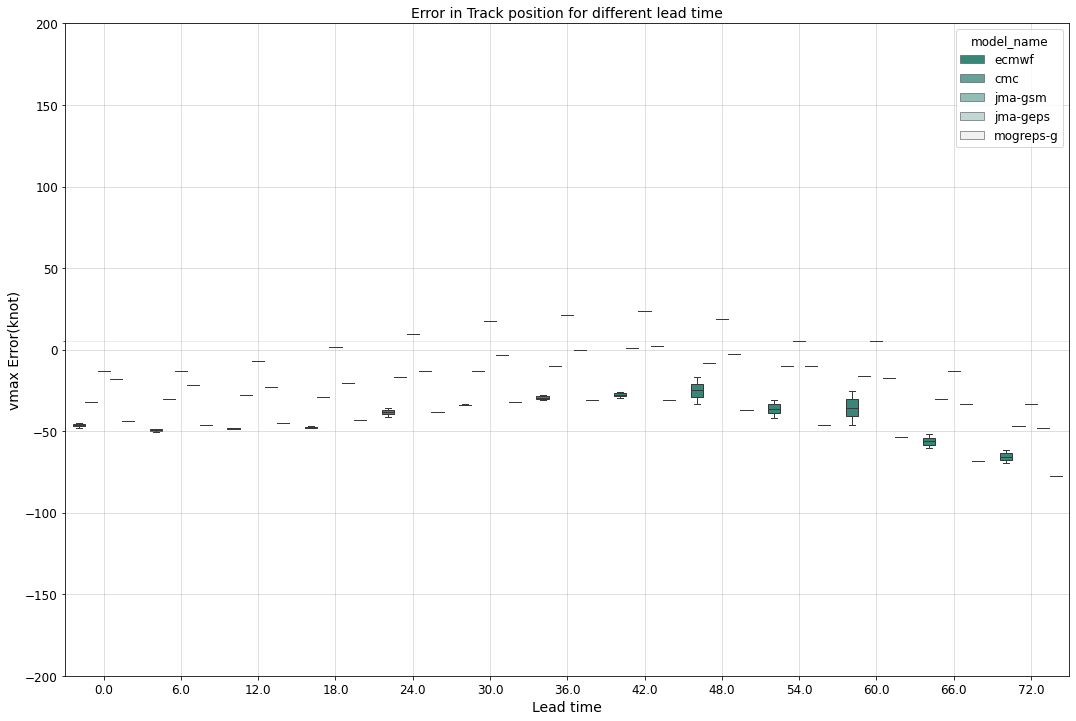

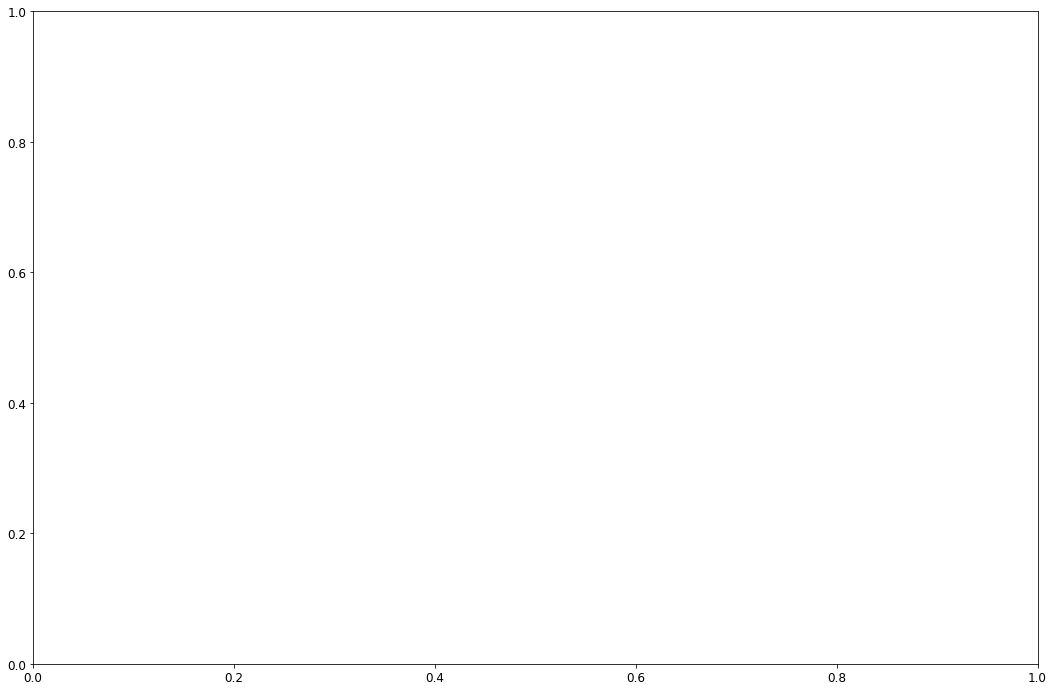

In [173]:
#
#df_obs=df_obs.set_index('time')
plt.rcParams.update({'font.size': 12})
for names in list(set(combined_df['NAME'])):
    combined_df_event=combined_df[combined_df['NAME']==names]
    combined_df_event['diff']=combined_df_event['cyc_speed']-combined_df_event['OBS_WIND']


    d1=combined_df_event[combined_df_event['forecast_time']==dict_typhoones[names.lower()]]
    d1=d1[d1['vhr']<=72]
    #d1=d1.set_index('time')
    #print(d1)

    fig, ax = plt.subplots(figsize=(18, 12))
    #ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
    #ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)

    ax = sns.boxplot(x="vhr", y="diff",hue="model_name", data=d1,
                     showfliers=False,
                     palette=sns.diverging_palette(170, 20, s=90, l=55, n=9,center='light'),linewidth=1)

    major_ticks = np.arange(0, 100, 20)
    minor_ticks = np.arange(0, 10, 5)
    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=0.5)
    #ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.set_ylim([-200,200])
    #sns.despine(left=True)
    #sns.despine(offset=5, trim=True);
    ax.set_title('Error in Track position for different lead time',fontsize=14)
    ax.set_xlabel('Lead time',fontsize=14)
    ax.set_ylabel('vmax Error(knot)',fontsize=14)



## Load data for event

C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'vmax Error(knot)')

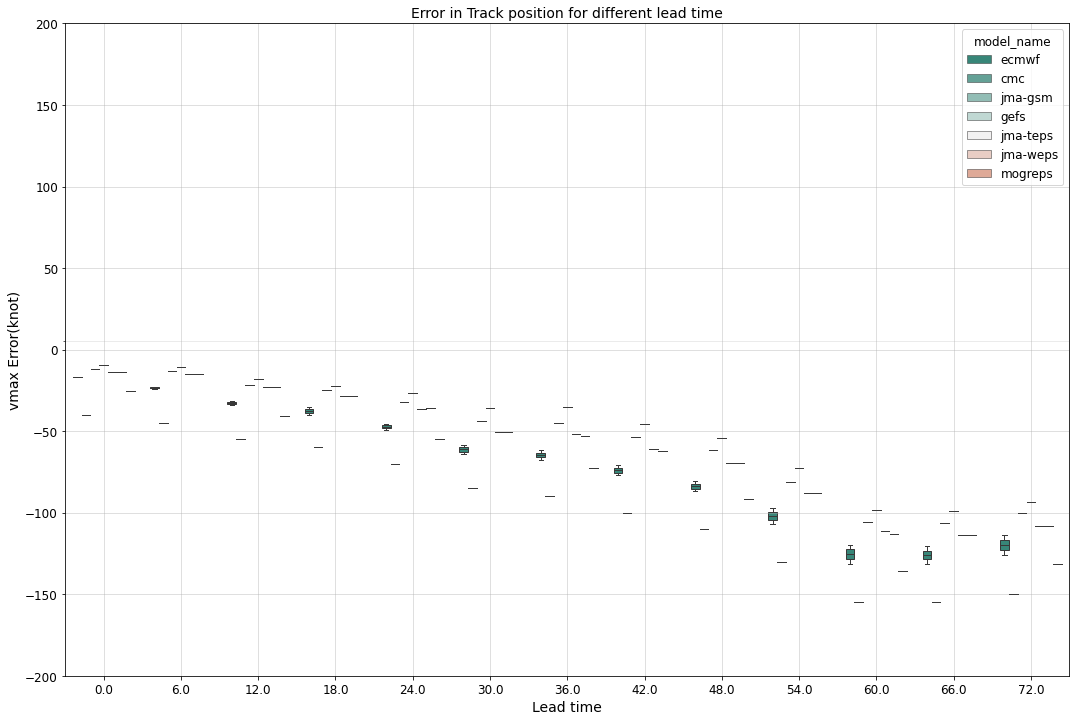

In [115]:
plt.subplot(321)
plt.scatter(x, y, s=80, c=z, marker=">")

plt.subplot(322)
plt.scatter(x, y, s=80, c=z, marker=(5, 0))

verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
plt.subplot(323)
plt.scatter(x, y, s=80, c=z, marker=verts)

plt.subplot(324)
plt.scatter(x, y, s=80, c=z, marker=(5, 1))

plt.subplot(325)
plt.scatter(x, y, s=80, c=z, marker='+')

plt.subplot(326)
plt.scatter(x, y, s=80, c=z, marker=(5, 2))

plt.show()

,model_name,forecast_time,cyc_speed,lat,lon,vhr,Mtype,NAME,SEASON,OBS_LAT,OBS_LON,OBS_WIND,diff
time,,,,,,,,,,,,,


In [106]:
d1

,model_name,forecast_time,cyc_speed,lat,lon,vhr,Mtype,NAME,SEASON,OBS_LAT,OBS_LON,OBS_WIND,diff
time,,,,,,,,,,,,,
2020-05-12 12:00:00,ecmwf,2020-05-12 12:00:00,20.100000,11.700000,129.300000,0.0,forecast,VONGFONG,2020,11.4,128.8,29,8.900000
2020-05-12 12:00:00,jma-gsm,2020-05-12 12:00:00,22.700000,10.700000,129.100000,0.0,forecast,VONGFONG,2020,11.4,128.8,29,6.300000
2020-05-12 12:00:00,ecmwf,2020-05-12 12:00:00,20.733333,11.707843,129.254902,0.0,ensembleforecast,VONGFONG,2020,11.4,128.8,29,8.266667
2020-05-12 12:00:00,jma-geps,2020-05-12 12:00:00,22.292593,10.751852,129.222222,0.0,ensembleforecast,VONGFONG,2020,11.4,128.8,29,6.707407
2020-05-12 12:00:00,mogreps-g,2020-05-12 12:00:00,12.455556,11.213889,128.819444,0.0,ensembleforecast,VONGFONG,2020,11.4,128.8,29,16.544444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16 18:00:00,cens,2020-05-15 00:00:00,30.894737,19.278947,120.673684,42.0,ensembleforecast,VONGFONG,2020,20.0,120.2,25,-5.894737
2020-05-16 18:00:00,ecmwf,2020-05-15 00:00:00,19.624000,19.070000,119.760000,42.0,ensembleforecast,VONGFONG,2020,20.0,120.2,25,5.376000
2020-05-16 18:00:00,jma-geps,2020-05-15 00:00:00,20.753846,19.753846,120.853846,42.0,ensembleforecast,VONGFONG,2020,20.0,120.2,25,4.246154


Text(0, 0.5, 'Track Error(km)')

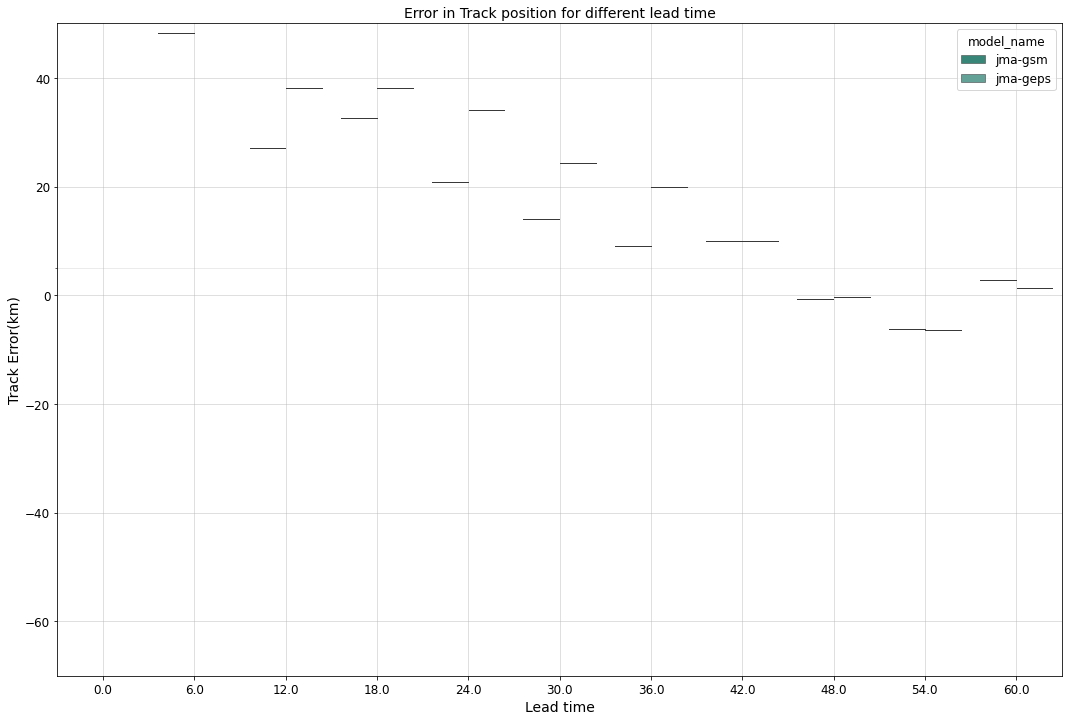

In [111]:
 
import seaborn as sns

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(18, 12))
#ax.subplots_adjust(left=0.2, wspace=0.025,hspace=0.1, top=0.90)
#ax = sns.boxplot(x="vhr", y="delta_x",hue="model_name", data=df1,showfliers=False,palette=sns.color_palette("cubehelix", n_colors=11),linewidth=1)

ax = sns.boxplot(x="vhr", y="diff",hue="model_name", data=d1,
                 showfliers=False,
                 palette=sns.diverging_palette(170, 20, s=90, l=55, n=9,center='light'),linewidth=1)

major_ticks = np.arange(0, 100, 20)
minor_ticks = np.arange(0, 10, 5)
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
#ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([-70,50])
#sns.despine(left=True)
#sns.despine(offset=5, trim=True);
ax.set_title('Error in Track position for different lead time',fontsize=14)
ax.set_xlabel('Lead time',fontsize=14)
ax.set_ylabel('Track Error(km)',fontsize=14)

#

#fig.savefig('C:\\globus_data\\PAR\\calculated_rations\\track_error2.jpg', format='jpg', dpi=400)
 

## Observations

In [123]:
df_obs = pd.read_csv(obs_folder+'ibtracs.WP.list.v04r00.csv') 
df_obs=df_obs[['SEASON','NUMBER','NAME','ISO_TIME','LAT','LON','WMO_WIND','USA_WIND','TOKYO_WIND', 'CMA_WIND', 'HKO_WIND']]
df_obs['time'] =  pd.to_datetime(df_obs['ISO_TIME'], format='%Y-%m-%d %H:%M:%S')


C:\Users\ATeklesadik\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20,23,24,25,38,39,40,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
df_event=df_obs[(df_obs['NAME'].isin(['hagupit','HAGUPIT'])) & (df_obs['SEASON']==2014)]
df_event=df_obs[(df_obs['NAME'].isin([cyclone_name.upper(),cyclone_name.lower()])) & (df_obs['SEASON']==int(landfall_72[:4]))]
df_store["lat"] = pd.to_numeric(df_store["lat"])
df_event=df_event.set_index('time')
df_event=df_event[df_event['WMO_WIND'] !=" "]
df_event["WMO_WIND"] = pd.to_numeric(df_event["WMO_WIND"])

 

In [195]:
df_obs

,SEASON,NUMBER,NAME,ISO_TIME,LAT,LON,WMO_WIND,USA_WIND,TOKYO_WIND,CMA_WIND,HKO_WIND,time
0,1884,14,NOT_NAMED,1884-06-24 16:00:00,16.5000,124.000,,,,,,1884-06-24 16:00:00
1,1884,14,NOT_NAMED,1884-06-24 18:00:00,16.5373,123.800,,,,,,1884-06-24 18:00:00
2,1884,14,NOT_NAMED,1884-06-24 21:00:00,16.5978,123.500,,,,,,1884-06-24 21:00:00
3,1884,14,NOT_NAMED,1884-06-25 00:00:00,16.6706,123.200,,,,,,1884-06-25 00:00:00
4,1884,14,NOT_NAMED,1884-06-25 03:00:00,16.7633,122.900,,,,,,1884-06-25 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
237574,2020,95,ATSANI,2020-11-07 00:00:00,22.6000,119.400,,51,,,,2020-11-07 00:00:00
237575,2020,95,ATSANI,2020-11-07 03:00:00,22.6799,119.315,,45,,,,2020-11-07 03:00:00
237576,2020,95,ATSANI,2020-11-07 06:00:00,22.7000,119.200,,39,,,,2020-11-07 06:00:00
237577,2020,95,ATSANI,2020-11-07 09:00:00,22.6653,118.945,,34,,,,2020-11-07 09:00:00


## Parameters

In [ ]:
##time_separation = 6
#time_limit_list = list(np.linspace(6,72,72/time_separation, dtype=int))
# time_limit_list = [72]

#institutes_selections = [['kwbc'], ['rjtd'], ['egrr'], ['ecmf'], ['kwbc', 'rjtd', 'egrr', 'ecmf'], ['kwbc', 'egrr', 'ecmf'], ['kwbc', 'rjtd', 'ecmf'], ['kwbc', 'ecmf']]
#selections_names = ['kwbc', 'rjtd', 'egrr', 'ecmf', 'full', 'w_rjtd', 'w_egrr', 'w_rjtd_egrr']
#selections_names = list(np.unique(df_store['model_name'].values))

#results = {}

In [137]:
list(set(df_store['vhr']))
df_list=[]
df_=df_store[df_store['Mtype']=='forecast'][['model_name','time','cyc_speed','lat','lon','vhr','Mtype']]
df_list.append(df_)
for vhr in list(set(df_store['vhr'])):
    df_store1=df_store[df_store['vhr']==vhr]
    df_ensamble=df_store1[df_store1['Mtype']=='ensembleforecast']
    df=df_ensamble.groupby(['model_name','time'], as_index=False).agg({"cyc_speed": "mean",
                                                                    "lat": "mean",
                                                                    "lon": "mean"})
    df['vhr']=vhr
    df['Mtype']='ensembleforecast'
    df_list.append(df)
df = pd.concat(df_list)
df['forecast_time']=df[['time','vhr']].apply(f, axis=1)

,model_name,time,cyc_speed,lat,lon,vhr,Mtype
0,mogreps,2014-12-16 12:00:00,11.05,6.95,112.15,360.0,ensembleforecast


In [138]:


 



landfall_time='2014-12-01 12:00:00'
df[df['forecast_time']==landfall_time]

,model_name,time,cyc_speed,lat,lon,vhr,Mtype,forecast_time
1,ecmwf,2014-12-01 12:00:00,23.10,5.90,150.80,0.0,forecast,2014-12-01 12:00:00
2,ecmwf,2014-12-01 18:00:00,22.10,6.30,149.30,6.0,forecast,2014-12-01 12:00:00
3,ecmwf,2014-12-02 00:00:00,23.70,6.50,147.50,12.0,forecast,2014-12-01 12:00:00
4,ecmwf,2014-12-02 06:00:00,24.70,6.60,146.10,18.0,forecast,2014-12-01 12:00:00
5,ecmwf,2014-12-02 12:00:00,24.70,7.00,144.50,24.0,forecast,2014-12-01 12:00:00
...,...,...,...,...,...,...,...,...
2,mogreps,2014-12-16 00:00:00,16.60,8.70,110.20,324.0,ensembleforecast,2014-12-02 12:00:00
0,mogreps,2014-12-15 12:00:00,14.80,7.60,113.00,336.0,ensembleforecast,2014-12-01 12:00:00
1,mogreps,2014-12-16 00:00:00,13.10,3.35,106.65,336.0,ensembleforecast,2014-12-02 00:00:00
0,mogreps,2014-12-16 00:00:00,13.25,7.60,112.70,348.0,ensembleforecast,2014-12-01 12:00:00


In [141]:
df[df['forecast_time']=='2014-12-01 12:00:00']

,model_name,time,cyc_speed,lat,lon,vhr,Mtype,forecast_time
1,ecmwf,2014-12-01 12:00:00,23.10,5.90,150.800000,0.0,forecast,2014-12-01 12:00:00
2,ecmwf,2014-12-01 18:00:00,22.10,6.30,149.300000,6.0,forecast,2014-12-01 12:00:00
3,ecmwf,2014-12-02 00:00:00,23.70,6.50,147.500000,12.0,forecast,2014-12-01 12:00:00
4,ecmwf,2014-12-02 06:00:00,24.70,6.60,146.100000,18.0,forecast,2014-12-01 12:00:00
5,ecmwf,2014-12-02 12:00:00,24.70,7.00,144.500000,24.0,forecast,2014-12-01 12:00:00
...,...,...,...,...,...,...,...,...
0,mogreps,2014-12-14 12:00:00,18.08,15.84,124.880000,312.0,ensembleforecast,2014-12-01 12:00:00
0,mogreps,2014-12-15 00:00:00,16.50,8.60,112.266667,324.0,ensembleforecast,2014-12-01 12:00:00
0,mogreps,2014-12-15 12:00:00,14.80,7.60,113.000000,336.0,ensembleforecast,2014-12-01 12:00:00
0,mogreps,2014-12-16 00:00:00,13.25,7.60,112.700000,348.0,ensembleforecast,2014-12-01 12:00:00


In [110]:
df_event_f=df[df['vhr']=='72']
df_event_f=df_event_f.set_index('time')
df_event_f

,model_name,cyc_speed,lat,lon,vhr,Mtype
time,,,,,,
"2014/12/04, 12:00:00",ecmwf,36.500000,11.000000,132.300000,72,forecast
"2014/12/05, 00:00:00",ecmwf,34.500000,11.500000,129.500000,72,forecast
"2014/12/05, 12:00:00",ecmwf,37.000000,10.800000,127.500000,72,forecast
"2014/12/06, 00:00:00",ecmwf,37.500000,10.700000,127.200000,72,forecast
"2014/12/06, 12:00:00",ecmwf,37.500000,11.000000,125.800000,72,forecast
...,...,...,...,...,...,...
"2014/12/08, 12:00:00",mogreps,19.066667,13.629167,123.491667,72,ensembleforecast
"2014/12/09, 00:00:00",mogreps,18.573913,13.539130,121.443478,72,ensembleforecast
"2014/12/09, 12:00:00",mogreps,17.036842,13.342105,118.626316,72,ensembleforecast


## Structure the results as a dictionary (for each time_limit)

Create a dictionary out of the results, with the following sctructure:

- number identifying institute and model:
    - institute-model name
    - cyclone name
        - number identifying the forecast time
            - forecast time (date and time at which the forecast was started)
            - ensemble
                - start
                - lat
                - lon
            - ensemble_mean
                - start
                - lat
                - lon
            - number_members_ensemble
        - number forecast times

In [ ]:
# Loop over time_limit_list
for time_limit in time_limit_list:
    
    print('Time limit: '+str(time_limit))

    # Initialise the dictonary
    results_t = {}

    # Create a list with time points
    nhours_list = list(np.linspace(0,time_limit,time_limit/time_separation+1, dtype=int))

    # Retrieve model names from the dataframe (the function set removes duplicates from a list)
    institute_names = list(set(df_store['institute_name']))

    # Initialise model_num (so that the first number will actually be 0)
    model_num = -1

    # Loop over cyclone names
    for cyclone_name in cyclone_names:

        # Initialise subdictionary
        results_t[cyclone_name] = {}

        # Restrict the dataframe to the specific cyclone
        df_cyclone = df_store[df_store['cycloneName']==cyclone_name]

        # Loop over institutes
        for institute_name in institute_names:

            # Restrict the dataframe to the specific institute
            df_institute = df_cyclone[df_cyclone['institute_name'] == institute_name]

            # Retrieve model names from the dataframe (the function set removes duplicates from a list)
            model_names = list(set(df_institute['model_name']))

            # Loop over models
            for model_name in model_names:

                model_num += 1

                # Initialise subdictionary and assign name
                results_t[cyclone_name][str(model_num)] = {}
                results_t[cyclone_name][str(model_num)]['model_name'] = institute_name.upper()+' - '+model_name

    #             print(model_num, results_t[cyclone_name][str(model_num)]['model_name'])

                # Restrict the dataframe to the specific model
                df_model = df_institute[df_institute['model_name'] == model_name]

                # Restrict the dataframe to the ensemble forecasts
                df_ensemble = df_model[df_model['Mtype'] == 'ensembleforecast']

                # For each model, each cyclone, retrieve the list of forecast times
                forecast_time_list = sorted(list(set(df_ensemble['forecast_time'])))
                results_t[cyclone_name][str(model_num)]['num_forecast_times'] = len(forecast_time_list)

                # Loop over forecast times
                for forecast_time_num, forecast_time in enumerate(forecast_time_list):

                    # Initialise lists for lat and lon of paths
                    lat_ensemble_list = []
                    lon_ensemble_list = []
                    date_ensemble_list = []

                    # Initialise subdictionary
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)] = {}
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['forecast_time'] = forecast_time

                    # Restrict the dataframe to the specific forecast time
                    df_time = df_ensemble[df_ensemble['forecast_time'] == forecast_time]

                    # Initialise subdictionary ensembles
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble'] = {}

                    # For each model, each cyclone, each forecast time, retrieve the list of ensembles
                    ensemble_list = sorted([int(x) for x in list(set(df_time['ensemble']))])
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['num_members_ensemble'] = len(ensemble_list)

                    # Loop over the member of the ensemble
                    for member in ensemble_list:

                        # Restrict the dataframe to the ensemble
                        df_member = df_time[df_time['ensemble'] == str(member)]

                        # Initialise lists for lat and lon of paths
                        lat_member = []
                        lon_member = []
                        date_member = []
                        date_int_member = []

                        # Loop over the time points
                        for nhours in nhours_list:
                            # Assign lat and lon
                            try:
                                lat_member.append(float(df_member[df_member['vhr']==str(nhours)]['lat']))
                                lon_member.append(float(df_member[df_member['vhr']==str(nhours)]['lon']))
                                date_member.append(list(df_member[df_member['vhr']==str(nhours)]['time'])[0])
                            except:
                                lat_member.append(np.nan)
                                lon_member.append(np.nan)
                                date_member.append('')

                        lat_ensemble_list.append(lat_member)
                        lon_ensemble_list.append(lon_member)
                        date_ensemble_list.append(date_member)

                    # Store lats and lons in the dictonary (as arrays)
                    try:
                        results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['start'] = list(df_member[df_member['vhr']==str(0)]['time'])[0]
                    except:
                        results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['start'] = ''

                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lat'] = np.array(lat_ensemble_list)
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lon'] = np.array(lon_ensemble_list)
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['date'] = date_ensemble_list

    results_t[cyclone_name]['number_models'] = model_num+1

    ## Crete average path over each ensemble

    for cyclone_name in cyclone_names:
        for model_num in range(results_t[cyclone_name]['number_models']):
                for forecast_time_num in range(results_t[cyclone_name][str(model_num)]['num_forecast_times']):
                    lat_ens = np.array(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lat'], dtype=np.float)
                    lon_ens = np.array(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lon'], dtype=np.float)
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean'] = {}
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['start'] = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['start']
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lat'] = np.nanmean(lat_ens,0)
                    results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lon'] = np.nanmean(lon_ens,0)
                    try:
                        results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['date'] = [sum_date_time(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['start'], hours=nhours) for nhours in nhours_list]
                    except:
                        results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['date'] = ''
            
            
                
    ##### UCL data    
    
    if include_UCL_data == 'y':

        results_t[cyclone_name]['UCL'] = {}

        for i,UCL_filename in enumerate(os.listdir(data_folder+'UCL/')):

            f = Dataset(data_folder+'UCL/'+UCL_filename)
            date_time_UCL = UCL_filename.split('_')[-1][:-3]
            lead_times = f.variables['forecast lead time'][:]
            forecast_time = date_time_UCL[0:4]+'/'+'05'+'/'+date_time_UCL[6:8]+', '+date_time_UCL[8:10]+':00:00'
            
            try:
            
                if lead_times[-1] > time_limit:
                    ind_lead_times_max = np.where(lead_times==time_limit)[0][0]
                    lead_times = lead_times[:ind_lead_times_max+1]
                else:
                    ind_lead_times_max = len(lead_times)

                results_t[cyclone_name]['UCL'][str(i)] = {}
                results_t[cyclone_name]['UCL'][str(i)]['forecast_time'] = forecast_time
                results_t[cyclone_name]['UCL'][str(i)]['lat'] = np.array(f.variables['storm forecast latitude'][:ind_lead_times_max+1])
                results_t[cyclone_name]['UCL'][str(i)]['lon'] = np.array(f.variables['storm forecast longitude'][:ind_lead_times_max+1])
                results_t[cyclone_name]['UCL'][str(i)]['date'] = [sum_date_time(forecast_time, hours=nhours) for nhours in lead_times]
                
            except:
                
                results_t[cyclone_name]['UCL'][str(i)] = {}
                results_t[cyclone_name]['UCL'][str(i)]['forecast_time'] = forecast_time
                results_t[cyclone_name]['UCL'][str(i)]['lat'] = np.nan
                results_t[cyclone_name]['UCL'][str(i)]['lon'] = np.nan
                results_t[cyclone_name]['UCL'][str(i)]['date'] = ''

        results_t[cyclone_name]['UCL']['num_forecast_times'] = i+1



    ##### Calculate multimodel means

    ## List of all forecast times (where each one appears only once)

    forecast_time_list = []

    for cyclone_name in cyclone_names:
        for model_num in range(results_t[cyclone_name]['number_models']):
                for forecast_time_num in range(results_t[cyclone_name][str(model_num)]['num_forecast_times']):
                    forecast_time_list.append(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['forecast_time'])

    forecast_time_list = sorted(list(set(forecast_time_list)))


    ## Create means for each selection of ensemble of models

    for cyclone_name in cyclone_names:
        results_t[cyclone_name]['multimodel'] = {}
        for s,selection in enumerate(institutes_selections):
            results_t[cyclone_name]['multimodel'][selections_names[s]] = {}
            for forecast_time_num_general,forecast_time in enumerate(forecast_time_list):
                n = 0
                lats = np.nan
                lons = np.nan
                for model_num in range(results_t[cyclone_name]['number_models']):
                    if results_t[cyclone_name][str(model_num)]['model_name'].split('-')[0].strip().lower() in selection:
                        for forecast_time_num in range(results_t[cyclone_name][str(model_num)]['num_forecast_times']):
                            if results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['forecast_time'] == forecast_time:
                                lat_ens = np.array(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lat'], dtype=np.float)
                                lon_ens = np.array(results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble']['lon'], dtype=np.float)
                                if n == 0:
                                    lats = lat_ens
                                    lons = lon_ens
                                else:
                                    lats = np.concatenate((lats,lat_ens),axis=0)
                                    lons = np.concatenate((lons,lon_ens),axis=0)
                                n += 1
                results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)] = {}
                results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['forecast_time'] = forecast_time
                results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['date'] = [sum_date_time(forecast_time, hours=nhours) for nhours in nhours_list]
                results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lat'] = np.nanmean(lats,0)
                results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lon'] = np.nanmean(lons,0)
    
                
    ##### Calculate errors respect to observations
    ## For each model

    # For each model

    for cyclone_name in cyclone_names:
#         print('Cyclone: '+cyclone_name+'\n')
        for model_num in range(results_t[cyclone_name]['number_models']):

            distance_initial_list = []
            distance_final_list = []

            for forecast_time_num in range(results_t[cyclone_name][str(model_num)]['num_forecast_times']):

                date_forecast = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['forecast_time']
                dates_list = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['date']

                for date_obs in obs['date_time']:

                    if date_obs in dates_list:

                        ind_final = dates_list.index(date_obs)

                        try:
                            lat_final = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lat'][ind_final]
                            lon_final = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lon'][ind_final]
                        except:
                            lat_final = np.nan
                            lon_final = np.nan

                        ind_final_obs = obs['date_time'].index(date_obs)
                        lat_final_obs = obs['track'][ind_final_obs,0]
                        lon_final_obs = obs['track'][ind_final_obs,1]

                        date_initial = sum_date_time(date_obs, hours=-time_limit)

                        if date_forecast == date_initial:

                            ind_initial = dates_list.index(date_forecast)

                            try:
                                lat_initial = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lat'][ind_initial]
                                lon_initial = results_t[cyclone_name][str(model_num)][str(forecast_time_num)]['ensemble_mean']['lon'][ind_initial]
                            except:
                                lat_initial = np.nan
                                lon_initial = np.nan

                            try:
                                ind_initial_obs = obs['date_time'].index(date_forecast)
                                lat_initial_obs = obs['track'][ind_initial_obs,0]
                                lon_initial_obs = obs['track'][ind_initial_obs,1]
                            except:
                                ind_initial_obs = np.nan
                                lat_initial_obs = np.nan
                                lon_initial_obs = np.nan

                            # Coordinates and distance

                            coords_final_theor = (lat_final_obs, lon_final_obs)
                            coords_final_model = (lat_final, lon_final)

                            coords_initial_theor = (lat_initial_obs, lon_initial_obs)
                            coords_initial_model = (lat_initial, lon_initial)

                            try:
                                distance_initial = geopy.distance.distance(coords_initial_theor, coords_initial_model).km
                            except:
                                distance_initial = np.nan

                            try:
                                distance_final = geopy.distance.distance(coords_final_theor, coords_final_model).km
                            except:
                                distance_final = np.nan

                            distance_initial_list.append(distance_initial)
                            distance_final_list.append(distance_final)

#                             print(results_t[cyclone_name][str(model_num)]['model_name'], date_forecast, '\t', distance_initial, distance_final)

            results_t[cyclone_name][str(model_num)]['distance_initial'] = np.nanmean(distance_initial_list)
            results_t[cyclone_name][str(model_num)]['distance_final'] = np.nanmean(distance_final_list)


    # For each multimodel ensemble
#         print('\n')

        for s in range(len(selections_names)):

            distance_initial_list = []
            distance_final_list = []

            for forecast_time_num_general in range(len(forecast_time_list)):

                date_forecast = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['forecast_time']
                dates_list = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['date']

                for date_obs in obs['date_time']:

                    if date_obs in dates_list:

                        ind_final = dates_list.index(date_obs)

                        try:
                            lat_final = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lat'][ind_final]
                            lon_final = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lon'][ind_final]
                        except:
                            lat_final = np.nan
                            lon_final = np.nan

                        ind_final_obs = obs['date_time'].index(date_obs)
                        lat_final_obs = obs['track'][ind_final_obs,0]
                        lon_final_obs = obs['track'][ind_final_obs,1]

                        date_initial = sum_date_time(date_obs, hours=-time_limit)

                        if date_forecast == date_initial:

                            ind_initial = dates_list.index(date_forecast)

                            try:
                                lat_initial = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lat'][ind_initial]
                                lon_initial = results_t[cyclone_name]['multimodel'][selections_names[s]][str(forecast_time_num_general)]['lon'][ind_initial]
                            except:
                                lat_initial = np.nan
                                lon_initial = np.nan

                            try:
                                ind_initial_obs = obs['date_time'].index(date_forecast)
                                lat_initial_obs = obs['track'][ind_initial_obs,0]
                                lon_initial_obs = obs['track'][ind_initial_obs,1]
                            except:
                                ind_initial_obs = np.nan
                                lat_initial_obs = np.nan
                                lon_initial_obs = np.nan

                            # Coordinates and distance

                            coords_final_theor = (lat_final_obs, lon_final_obs)
                            coords_final_model = (lat_final, lon_final)

                            coords_initial_theor = (lat_initial_obs, lon_initial_obs)
                            coords_initial_model = (lat_initial, lon_initial)

                            try:
                                distance_initial = geopy.distance.distance(coords_initial_theor, coords_initial_model).km
                            except:
                                distance_initial = np.nan

                            try:
                                distance_final = geopy.distance.distance(coords_final_theor, coords_final_model).km
                            except:
                                distance_final = np.nan

                            distance_initial_list.append(distance_initial)
                            distance_final_list.append(distance_final)

#                             print(selections_names[s], date_forecast, '\t', distance_initial, distance_final)

            results_t[cyclone_name]['multimodel'][selections_names[s]]['distance_initial'] = np.nanmean(distance_initial_list)
            results_t[cyclone_name]['multimodel'][selections_names[s]]['distance_final'] = np.nanmean(distance_final_list)


    # For UCL
        if include_UCL_data == 'y':
#         print('\n')

            distance_initial_list = []
            distance_final_list = []

            for forecast_time_num_general in range(results_t[cyclone_name]['UCL']['num_forecast_times']):

                date_forecast = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['forecast_time']
                dates_list = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['date']

                for date_obs in obs['date_time']:

                    if date_obs in dates_list:

                        ind_final = dates_list.index(date_obs)

                        try:
                            lat_final = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['lat'][ind_final]
                            lon_final = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['lon'][ind_final]
                        except:
                            lat_final = np.nan
                            lon_final = np.nan

                        ind_final_obs = obs['date_time'].index(date_obs)
                        lat_final_obs = obs['track'][ind_final_obs,0]
                        lon_final_obs = obs['track'][ind_final_obs,1]

                        date_initial = sum_date_time(date_obs, hours=-time_limit)

                        if date_forecast == date_initial:

                            ind_initial = dates_list.index(date_forecast)

                            try:
                                lat_initial = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['lat'][ind_initial]
                                lon_initial = results_t[cyclone_name]['UCL'][str(forecast_time_num_general)]['lon'][ind_initial]
                            except:
                                lat_initial = np.nan
                                lon_initial = np.nan

                            try:
                                ind_initial_obs = obs['date_time'].index(date_forecast)
                                lat_initial_obs = obs['track'][ind_initial_obs,0]
                                lon_initial_obs = obs['track'][ind_initial_obs,1]
                            except:
                                ind_initial_obs = np.nan
                                lat_initial_obs = np.nan
                                lon_initial_obs = np.nan

                            # Coordinates and distance

                            coords_final_theor = (lat_final_obs, lon_final_obs)
                            coords_final_model = (lat_final, lon_final)

                            coords_initial_theor = (lat_initial_obs, lon_initial_obs)
                            coords_initial_model = (lat_initial, lon_initial)

                            try:
                                distance_initial = geopy.distance.distance(coords_initial_theor, coords_initial_model).km
                            except:
                                distance_initial = np.nan

                            try:
                                distance_final = geopy.distance.distance(coords_final_theor, coords_final_model).km
                            except:
                                distance_final = np.nan

                            distance_initial_list.append(distance_initial)
                            distance_final_list.append(distance_final)

#                             print('UCL', date_forecast, '\t', distance_initial, distance_final)

            results_t[cyclone_name]['UCL']['distance_initial'] = np.nanmean(distance_initial_list)
            results_t[cyclone_name]['UCL']['distance_final'] = np.nanmean(distance_final_list)
            
    results[str(time_limit)] = results_t

## Calculate errors averaging over all the times considered

In [ ]:
results['average_time'] = {}

for cyclone_name in cyclone_names:
    
    # Initialise dictionary for the specific cyclone
    results['average_time'][cyclone_name] = {}
    
    # Single models
    for model_num in range(results[str(time_limit_list[0])][cyclone_name]['number_models']):
        results['average_time'][cyclone_name][str(model_num)] = {}
        results['average_time'][cyclone_name][str(model_num)]['distance_final'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name][str(model_num)]['distance_final'] for i in range(len(time_limit_list))])
        results['average_time'][cyclone_name][str(model_num)]['distance_initial'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name][str(model_num)]['distance_initial'] for i in range(len(time_limit_list))])
    
    # Multimodels
    results['average_time'][cyclone_name]['multimodel'] = {}
    
    for s in range(len(selections_names)):
        results['average_time'][cyclone_name]['multimodel'][selections_names[s]] = {}
        results['average_time'][cyclone_name]['multimodel'][selections_names[s]]['distance_final'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name]['multimodel'][selections_names[s]]['distance_final'] for i in range(len(time_limit_list))])
        results['average_time'][cyclone_name]['multimodel'][selections_names[s]]['distance_initial'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name]['multimodel'][selections_names[s]]['distance_initial'] for i in range(len(time_limit_list))])
    
    # UCL
    results['average_time'][cyclone_name]['UCL'] = {}
    results['average_time'][cyclone_name]['UCL']['distance_final'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name]['UCL']['distance_final'] for i in range(len(time_limit_list))])
    results['average_time'][cyclone_name]['UCL']['distance_initial'] = np.nanmean([results[str(time_limit_list[i])][cyclone_name]['UCL']['distance_initial'] for i in range(len(time_limit_list))])
    

## Plots single models

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 20
width = 0.05  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

for t in range(len(time_limit_list_tot)):
    err[str(t)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))
results_t[cyclone_name]['number_models']

for s in range(results[time_limit_list_tot[0]][cyclone_name]['number_models']):
    labels.append(results[time_limit_list_tot[0]][cyclone_name][str(s)]['model_name'])
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name][str(s)]['distance_final'])
        
if include_UCL_data == 'y':
    labels.append('UCL')
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_final'])
        

x = np.arange(len(labels))  # the label locations

if len(time_limit_list_tot) % 2:
    positions = list(range(-int(len(time_limit_list_tot)/2),0))+[0]+list(range(1,int(len(time_limit_list_tot)/2)+1))
else:
    positions = list(np.arange(-int(len(time_limit_list_tot)/2)+0.5,0,1))+list(np.arange(0.5,int(len(time_limit_list_tot)/2),1))

for t in range(len(time_limit_list_tot)):
    rects[str(t)] = ax.bar(x + width*positions[t], err[str(t)], width, label=time_limit_list_tot[t])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Extreme sync index ('+str(std_dev)+' std dev)');
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Models', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()
# fig.savefig(figures_folder+'error_singlemodels_by_model_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 25
width = 0.07  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

model_names = [results[str(time_limit_list[0])][cyclone_name][str(s)]['model_name'] for s in range(results[str(time_limit_list[0])][cyclone_name]['number_models'])]

if include_UCL_data == 'y':
    tot_selection_len = results[str(time_limit_list[0])][cyclone_name]['number_models']+1
    tot_selection_names = model_names+['UCL']
else:
    tot_selection_len = results[str(time_limit_list[0])][cyclone_name]['number_models']
    tot_selection_names = model_names

for s in range(tot_selection_len):
    err[str(s)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))


for t in range(len(time_limit_list_tot)):
    labels.append(time_limit_list_tot[t])
    for s in range(tot_selection_len):
        if s < tot_selection_len-1:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name][str(s)]['distance_final'])
        else:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_final'])

            
x = np.arange(len(labels))  # the label locations

if tot_selection_len % 2:
    positions = list(range(-int(tot_selection_len/2),0))+[0]+list(range(1,int(tot_selection_len/2)+1))
else:
    positions = list(np.arange(-int(tot_selection_len/2)+0.5,0,1))+list(np.arange(0.5,int(tot_selection_len/2),1))

for s in range(tot_selection_len):
    rects[str(s)] = ax.bar(x + width*positions[s], err[str(s)], width, label=str(tot_selection_names[s]))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Lead time (hours)', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()
# fig.savefig(figures_folder+'error_singlemodels_by_leadtime_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 20
width = 0.05  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

for t in range(len(time_limit_list_tot)):
    err[str(t)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))
results_t[cyclone_name]['number_models']

for s in range(results[time_limit_list_tot[0]][cyclone_name]['number_models']):
    labels.append(results[time_limit_list_tot[0]][cyclone_name][str(s)]['model_name'])
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name][str(s)]['distance_initial'])
        
if include_UCL_data == 'y':
    labels.append('UCL')
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_initial'])
        

x = np.arange(len(labels))  # the label locations

if len(time_limit_list_tot) % 2:
    positions = list(range(-int(len(time_limit_list_tot)/2),0))+[0]+list(range(1,int(len(time_limit_list_tot)/2)+1))
else:
    positions = list(np.arange(-int(len(time_limit_list_tot)/2)+0.5,0,1))+list(np.arange(0.5,int(len(time_limit_list_tot)/2),1))

for t in range(len(time_limit_list_tot)):
    rects[str(t)] = ax.bar(x + width*positions[t], err[str(t)], width, label=time_limit_list_tot[t])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Extreme sync index ('+str(std_dev)+' std dev)');
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Models', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()


## Plots multimodel

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 30
width = 0.05  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

for t in range(len(time_limit_list_tot)):
    err[str(t)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))


for s in range(len(selections_names)):
    labels.append(selections_names[s])
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name]['multimodel'][selections_names[s]]['distance_final'])
        
if include_UCL_data == 'y':
    labels.append('UCL')
    for t in range(len(time_limit_list_tot)):
        err[str(t)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_final'])
        

x = np.arange(len(labels))  # the label locations

if len(time_limit_list_tot) % 2:
    positions = list(range(-int(len(time_limit_list_tot)/2),0))+[0]+list(range(1,int(len(time_limit_list_tot)/2)+1))
else:
    positions = list(np.arange(-int(len(time_limit_list_tot)/2)+0.5,0,1))+list(np.arange(0.5,int(len(time_limit_list_tot)/2),1))

for t in range(len(time_limit_list_tot)):
    rects[str(t)] = ax.bar(x + width*positions[t], err[str(t)], width, label=time_limit_list_tot[t])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Extreme sync index ('+str(std_dev)+' std dev)');
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Models', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()
# fig.savefig(figures_folder+'error_multimodels_by_model_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 25
width = 0.08  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

if include_UCL_data == 'y':
    tot_selection_len = len(selections_names)+1
    tot_selection_names = selections_names+['UCL']
else:
    tot_selection_len = len(selections_names)
    tot_selection_names = selections_names

for s in range(tot_selection_len):
    err[str(s)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))


for t in range(len(time_limit_list_tot)):
    labels.append(time_limit_list_tot[t])
    for s in range(tot_selection_len):
        if s < tot_selection_len-1:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name]['multimodel'][selections_names[s]]['distance_final'])
        else:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_final'])

            
x = np.arange(len(labels))  # the label locations

if tot_selection_len % 2:
    positions = list(range(-int(tot_selection_len/2),0))+[0]+list(range(1,int(tot_selection_len/2)+1))
else:
    positions = list(np.arange(-int(tot_selection_len/2)+0.5,0,1))+list(np.arange(0.5,int(tot_selection_len/2),1))

for s in range(tot_selection_len):
    rects[str(s)] = ax.bar(x + width*positions[s], err[str(s)], width, label=str(tot_selection_names[s]))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Lead time (hours)', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()
# fig.savefig(figures_folder+'error_multimodels_by_leadtime_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

## Final plot

In [ ]:
selections_names

In [ ]:
selections_better_names = ['KWBC', 'RJTD', 'EGRR', 'ECMWF', 'KWBC + RJTD + EGRR + ECMWF', 'KWBC + EGRR + ECMWF', 'KWBC + RJTD + ECMWF', 'KWBC + ECMWF']

In [ ]:
# Plot errors depending on leading times

include_average_time = 'y'

plt.rcParams['font.size'] = 25
width = 0.08  # the width of the bars

labels = []
err = {}
rects = {}

if include_average_time == 'y':
    time_limit_list_tot = [str(x) for x in time_limit_list]+['average_time']
else:
    time_limit_list_tot = [str(x) for x in time_limit_list]

if include_UCL_data == 'y':
    tot_selection_len = len(selections_names)+1
    tot_selection_names = selections_better_names+['UCL']
else:
    tot_selection_len = len(selections_names)
    tot_selection_names = selections_better_names

for s in range(tot_selection_len):
    err[str(s)] = []

title_string = 'Cyclone: '+cyclone_name

fig, ax = plt.subplots(1, 1, figsize=(30,12))


for t in range(len(time_limit_list_tot)):
    labels.append(time_limit_list_tot[t])
    for s in range(tot_selection_len):
        if s < tot_selection_len-1:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name]['multimodel'][selections_names[s]]['distance_final'])
        else:
            err[str(s)].append(results[time_limit_list_tot[t]][cyclone_name]['UCL']['distance_final'])

            
x = np.arange(len(labels))  # the label locations

if tot_selection_len % 2:
    positions = list(range(-int(tot_selection_len/2),0))+[0]+list(range(1,int(tot_selection_len/2)+1))
else:
    positions = list(np.arange(-int(tot_selection_len/2)+0.5,0,1))+list(np.arange(0.5,int(tot_selection_len/2),1))
    
    
# Order selection by median of average times
selection_ordered = sorted(zip([np.median(err[str(s)][-1]) for s in range(tot_selection_len)], list(range(tot_selection_len))))
selection_ordered = [x[1] for x in selection_ordered]


for i,s in enumerate(selection_ordered):
    rects[str(s)] = ax.bar(x + width*positions[i], err[str(s)], width, label=str(tot_selection_names[s]))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error (km)', labelpad = 20)
ax.set_xlabel('Lead time (hours)', labelpad = 20)
ax.yaxis.grid()
ax.legend();

ttl = ax.set_title(title_string, fontweight='bold')
ttl.set_position([0.5, 1.05])

plt.tight_layout()
# fig.savefig(figures_folder+'error_multimodels_by_leadtime_'+cyclone_name+'.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig(figures_folder+'error_multimodels_by_leadtime_'+cyclone_name+'.png', format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0)